This notebook is about visualizing the ripple modulation in the ABI Visual Behaviour Neuropixels dataset on neurons within the hippocampus as well as 

In [31]:
# libraries
import os
import re
import subprocess 
import numpy as np
import pandas as pd
from scipy import io, signal
#from fitter import Fitter, get_common_distributions, get_distributions
import scipy.ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
# for ripple detection
import ripple_detection
from ripple_detection.simulate import simulate_time
from scipy import signal
import seaborn as sns
#import KernelRegDraft as kreg # custom module, not needed
#import 'Stienmetz2019Reanalyzed/KernelRegDraft.py' as kreg
import piso #can be difficult to install, https://piso.readthedocs.io/en/latest/
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from tqdm import tqdm
import piso
from ripple_detection.simulate import simulate_time
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import xarray as xr


In [32]:
# setting paths
# change this as needed:
sdk_cache_dir='/space/scratch/allen_visbehave_data'# path to where the cache for the allensdk is (wehre the lfp is going)
manifest_path = os.path.join(sdk_cache_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
input_dir = '/space/scratch/allen_visbehave_swr_data_test'
output_dir = os.path.curdir


In [33]:
# Functions

def check_overlap(df1, df2, offset=0):
    # returns true or false if there is overlap between the two dataframes with start_time and end_time columns
    result = []

    for i in range(len(df1)):
        start_time_1, end_time_1 = df1.loc[i, 'start_time'] - offset, df1.loc[i, 'end_time'] + offset
        overlap = any((start_time_2 < end_time_1 and end_time_2 > start_time_1) for start_time_2, end_time_2 in zip(df2['start_time'], df2['end_time']))
        result.append(overlap)

    return result


def merge_intervals(intervals, x_offset=0):
    """
    Merges overlapping intervals within a list of intervals
    Convert intervals into sets of tuples then merge with this function
    
    parameters
    intervals : list of tuples
    x_offset : int, optional, time offset to merge intervals
    
    Returns a list of merged intervals
    """
    intervals.sort(key=lambda interval: interval[0])

    stack = [intervals[0]]
    for current in intervals[1:]:
        last = stack[-1]
        if current[0] <= last[1] + x_offset:
            stack[-1] = (last[0], max(last[1], current[1]))
        else:
            stack.append(current)
    
    return stack

# Function to convert DataFrame to set of tuples (start_time, end_time)
def dataframe_to_interval_set(df):
    interval_set = set()
    for index, row in df.iterrows():
        interval_set.add((row['start_time'], row['end_time']))
    return interval_set

def union_of_lists_of_interval_sets(list_of_interval_sets):
    """
    Takes a list of lists of interval sets and returns the union of all
    interval sets in the list
    
    parameters
    list_of_interval_sets : list of lists of interval sets
    
    Returns a list of merged intervals
    """
    union = set()
    for interval_set in list_of_interval_sets:
        union = union.union(interval_set)
    return union


def union_of_event_times(list_of_event_intervals_df, offset=0):
    """
    Returns the union of all event times in a list of DataFrames
    Parameters
    ----------
    list_of_event_intervals_df : list of DataFrames
        Each DataFrame should have columns 'start_time' and 'end_time'
    offset : int, optional, time offset to merge intervals
    Returns
    -------     
    list : list of tuples
        Each tuple is an event time interval
    """
    set_list = []
    for df in list_of_event_intervals_df:
        set_list.append(dataframe_to_interval_set(df))
    
    union = union_of_lists_of_interval_sets(set_list)
    
    return merge_intervals(list(union), x_offset=offset)

def dataframe_union_of_event_times(list_of_event_intervals_df, offset=0, event_name='event'):
    """
    Returns the union of all event times in a list of DataFrames
    Parameters
    ----------
    list_of_event_intervals_df : list of DataFrames
        Each DataFrame should have columns 'start_time' and 'end_time'
    offset : int, optional, time offset to merge intervals
    Returns
    -------     
    DataFrame : DataFrame of event times
        Columns are 'start_time' and 'end_time'
    """
    union = union_of_event_times(list_of_event_intervals_df, offset=offset)
    union_df = pd.DataFrame(union, columns=['start_time', 'end_time'])
    union_df[event_name] = union_df.index
    return union_df

def add_overlap_probes(df, df_dict, overlap_col_name='overlap_probes'):
    """
    Adds a column to a DataFrame that lists the probes that overlap with putative global event created from
    the union of the DataFrames in df_dict
    Parameters
    ----------
    df : DataFrame
        DataFrame with columns 'start_time' and 'end_time'
    df_dict : dict
        Dictionary of DataFrames with columns 'start_time' and 'end_time'
    overlap_col_name : str, optional, name of column to add to df
    Returns
    -------
    DataFrame : DataFrame with new column 'overlap_probes'
    """
    overlap_probes = []
    for i, row in df.iterrows():
        overlap_probes_row = []
        for key, df_probe in df_dict.items():
            overlap = any((df_probe['start_time'] < row['end_time']) & (df_probe['end_time'] > row['start_time']))
            if overlap:
                overlap_probes_row.append(key)
        overlap_probes.append(overlap_probes_row)
    df[overlap_col_name] = overlap_probes
    return df

def find_channel_num_in_filename(unfilterd_swr_path, criteria1, criteria2):
    """
    Finds the channel number in the filename of the unfiltered swr file
    Parameters
    ----------
    unfilterd_swr_path : str
        Path to the unfiltered swr file (e.g. '/space/scratch/allen_visbehave_swr_data_test/filtered_lfp/filtered_lfp_0.mat')
    criteria1 : str 
        Criteria to find in the filename (e.g. 'filtered_lfp')
    criteria2 : str
        Criteria to find in the filename (e.g. 'channel')
    Returns
    -------
    int : channel number
    """
    filenames = np.array(os.listdir(unfilterd_swr_path))
    mask = np.array([], dtype=bool)
    for filename in filenames:
        if criteria1 in filename and criteria2 in filename:
            mask = np.append(mask,True)
        else:
            mask = np.append(mask,False)
    filename = str(filenames[mask])
    start = filename.find('channel_') + len('channel_')
    end = filename.find('_', start)
    result = filename[start:end] if start != -1 and end != -1 else None
    return int(result)

def unit_spike_times_alyx_format(session_obj, unit_ids, start_time=0, stop_time=np.inf, as_array=False):
    """
    Returns a DataFrame of spike times for multiple units in a session in the format
    according to the Alyx format
    
    Parameters
    ----------
    session : allensdk session object
    unit_ids : list of unit ids (obtained by session.units.index)
    start_time : float, optional, start time of spike times
    stop_time : float, optional, stop time of spike times
    as_array : bool, optional, if True returns a numpy array instead of a DataFrame
    
    Returns
    -------
    DataFrame or numpy array of spike times
    """
    df = pd.DataFrame(columns=['units', 'times'])

    for unit_id in unit_ids:
        ca1_unit_time = np.array(session_obj.spike_times[unit_id])
        filtered_time = ca1_unit_time[(ca1_unit_time > start_time) & (ca1_unit_time < stop_time)]
        unit_ids_array = np.full(filtered_time.shape, unit_id)
        
        df_temp = pd.DataFrame({
            'units': unit_ids_array,
            'times': filtered_time
        })
        
        df = df = pd.concat([df, df_temp], ignore_index=True)

    df = df.sort_values(by='times')

    if as_array:
        return df.values
    else:
        return df
    
#For smoothing we make halfguassian_kernel1d and halfgaussian_filter1d
def halfgaussian_kernel1d(sigma, radius):
    """
    Computes a 1-D Half-Gaussian convolution kernel.
    """
    sigma2 = sigma * sigma
    x = np.arange(0, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()

    return phi_x

def halfgaussian_filter1d(input, sigma, axis=-1, output=None,
                      mode="constant", cval=0.0, truncate=4.0):
    """
    Convolves a 1-D Half-Gaussian convolution kernel.
    """
    sd = float(sigma)
    # make the radius of the filter equal to truncate standard deviations
    lw = int(truncate * sd + 0.5)
    weights = halfgaussian_kernel1d(sigma, lw)
    origin = -lw // 2
    return scipy.ndimage.convolve1d(input, weights, axis, output, mode, cval, origin)

# Assuming you have your signal_array, b, and a defined as before
def finitimpresp_filter_for_LFP(LFP_array, samplingfreq, lowcut = 1, highcut = 250,
                    filter_order = 101):
    
    nyquist = 0.5 * samplingfreq

    # Design the FIR bandpass filter using scipy.signal.firwin
    fir_coeff = signal.firwin(filter_order, [lowcut / nyquist, highcut / nyquist],
                              pass_zero=False, fs=samplingfreq)

    # Apply the FIR filter to your signal_array
    #filtered_signal = signal.convolve(LFP_array, fir_coeff, mode='same', method='auto')
    filtered_signal = signal.lfilter(fir_coeff, 1.0, LFP_array, axis=0)
    return(filtered_signal)



In [34]:
eventspersession_df = pd.read_csv('/space/scratch/allen_visbehave_swr_data_test/filtered_swrs/eventspersession_df.csv', index_col=0)
# Convert 'probe_id' and 'session_id' to a category type
eventspersession_df.head()

,session_id,probe_id,ripple_number,ripple_number_logep1,within_lognormal_bounds
0,750749662,769322808,490,2.691081,True
1,750749662,769322804,97,1.991226,True
2,750749662,769322810,320,2.506505,True
3,750749662,769322812,158,2.201397,True
4,750749662,769322806,59,1.778151,False


In [35]:
input_dir

'/space/scratch/allen_visbehave_swr_data_test'

In [36]:
eventspersession_df = eventspersession_df[eventspersession_df.within_lognormal_bounds==True]

In [40]:
os.path.join(filt_sesh_path, 'session_{}_probe_{}_filtered_swrs.csv'.format(session_id, probe_id))

'/space/scratch/allen_visbehave_swr_data_test/filtered_swrs/session_750749662_probe_769322808_filtered_swrs.csv'

In [42]:
# computing global ripples
session_list = eventspersession_df['session_id'].unique()
session_id = session_list[0]
sesh_path = os.path.join(input_dir, 'swrs_session_{}'.format(session_id))
sessions = cache.get_session_table()
session = cache.get_session_data(session_id)
probe_event_dict = {}
filt_sesh_path = os.path.join(input_dir, 'filtered_swrs')
putative_global_ripples = pd.read_csv(os.path.join(filt_sesh_path, 'swrs_session_{}'.format(session_id), 'session_{}_putative_global_swrs.csv'.format(session_id)), index_col=0)
probe_list = eventspersession_df.probe_id[eventspersession_df.session_id==session_id].unique()
for probe_id in probe_list:
        probe_event_dict[probe_id] = pd.read_csv(os.path.join(filt_sesh_path,'swrs_session_{}'.format(session_id), 'session_{}_probe_{}_filtered_swrs.csv'.format(session_id, probe_id)), index_col=0)
probe_id = probe_list[0]
# as the lsits have become strings by storing them you need to count the number of commas
numprobes = putative_global_ripples.probes_event_is_on.apply(lambda x: x.count(','))
num_probes_min = 2
num_commas = 1
global_ripples = putative_global_ripples[numprobes > num_commas]
global_ripples.head()

,start_time,end_time,putative_global_event_id,probes_event_is_on
0,11.227134,11.365650,0,"[769322808, 769322810, 769322812]"
103,2315.874762,2316.105162,103,"[769322804, 769322812, 769322802]"
135,2590.934417,2591.253395,135,"[769322804, 769322812, 769322802]"
145,2650.012650,2650.194232,145,"[769322808, 769322804, 769322802]"
185,3126.222713,3126.387513,185,"[769322808, 769322804, 769322802]"


In [43]:
lfp = session.get_lfp(probe_id)
SAMPLING_FREQUENCY = session.probes.lfp_sampling_rate[probe_id]

In [44]:
probe_id = probe_list[0]

unfilt_sesh_path = os.path.join(input_dir, 'swrs_session_{}'.format(session_id))
channel_id = find_channel_num_in_filename(sesh_path, criteria1='probe_'.format(probe_id), criteria2= 'karlsson_detector_events')
channel_id

850168062

In [45]:
# some functions for signal processing and time series manipulation


# Assuming you have your signal_array, b, and a defined as before
def finitimpresp_filter_for_LFP(LFP_array, samplingfreq, lowcut = 1, highcut = 250,
                    filter_order = 101):
    
    nyquist = 0.5 * samplingfreq

    # Design the FIR bandpass filter using scipy.signal.firwin
    fir_coeff = signal.firwin(filter_order, [lowcut / nyquist, highcut / nyquist],
                              pass_zero=False, fs=samplingfreq)

    # Apply the FIR filter to your signal_array
    #filtered_signal = signal.convolve(LFP_array, fir_coeff, mode='same', method='auto')
    filtered_signal = signal.lfilter(fir_coeff, 1.0, LFP_array, axis=0)
    return(filtered_signal)


def event_boundary_detector(time, five_to_fourty_band_power_df, envelope=True, minimum_duration = 0.02, maximum_duration = 0.4,
                       threshold_sd=2.5, envelope_threshold_sd=1):
    """
    Power threshold event detector, includes an envelope as well if wanted
    
    Originally for detecting sharp waves in the striatum radiatum, takes in power signal from 
    
    From Fernández-Ruiz, A., Oliva, A., Fermino de Oliveira, E., Rocha-Almeida, F., Tingley, D., 
    & Buzsáki, G. (2019). Long-duration hippocampal sharp wave ripples improve memory. Science, 364(6445), 1082-1086.
    
    
    Sharp waves were detected separately using LFP from a CA1 str. radiatum channel, filtered with band-pass filter boundaries
   (5-40 Hz). LFP events of a minimum duration of 20 ms and maximum 400 ms exceeding 2.5 SD of the
   background signal were included as candidate SPWs. Only if a SPW was simultaneously detected with
   a ripple, a CA1 SPW-R event was retained for further analysis. SPW-R bursts were classified when more
   than one event was detected in a 400 ms time window.
    
    """
    
    # make df to fill
    row_of_info =  {
        'start_time': [],
        'end_time': [],
        'duration': [],
        }

    #sharp_wave_events_df = pd.DataFrame()
    #scored_wave_power = stats.zscore(five_to_fourty_band_df)
    
    # compute our power threshold
    #wave_band_sd_thresh = np.std(five_to_fourty_band_df)*threshold_sd
    five_to_fourty_band_power_df = stats.zscore(five_to_fourty_band_power_df)
    past_thresh = five_to_fourty_band_power_df>=threshold_sd
    
    # now we expand the sections that are past thresh up to the points that 
    # are past the envelope thresh, so not all sections above envelope thresh are true
    # but those sections which alse contain a region past the detection threshold are included
    def expand_sections(z_scores, boolean_array, thresh):
        # Find indices where boolean_array is True
        true_indices = np.where(boolean_array)[0]

        # Initialize an array to keep track of expanded sections
        expanded_sections = np.zeros_like(z_scores, dtype=bool)

        # Iterate over true_indices and expand sections
        for index in true_indices:
            # Find the start and end of the current section
            start = index
            end = index

            # Expand section to the left (while meeting conditions)
            while start > 0 and z_scores[start - 1] >  thresh:
                start -= 1

            # Expand section to the right (while meeting conditions)
            while end < len(z_scores) - 1 and z_scores[end + 1] >  thresh:
                end += 1

            # Check if the expanded section contains a point above envelope_threshold_sd in z_scores
            if any(z_scores[start:end + 1] >  thresh):
                expanded_sections[start:end + 1] = True

        # Update the boolean_array based on expanded_sections
        boolean_array = boolean_array | expanded_sections

        return boolean_array
    
    if envelope==True:
        past_thresh = expand_sections(z_scores=five_to_fourty_band_power_df,
                                  boolean_array= past_thresh,
                                  thresh = envelope_threshold_sd)
    
    
    # Find the indices where consecutive True values start
    starts = np.where(past_thresh & ~np.roll(past_thresh, 1))[0]
    row_of_info['start_time'] = time[starts]
    # Find the indices where consecutive True values end
    ends = np.where(past_thresh & ~np.roll(past_thresh, -1))[0]
    row_of_info['end_time'] = time[ends]
    
    row_of_info['duration'] = [row_of_info['end_time'][i]-row_of_info['start_time'][i] for i in range(0,len(row_of_info['start_time']))]
    
    #turn the dictionary into adataframe
    sharp_wave_events_df = pd.DataFrame(row_of_info)
    
    # filter for the duration range we want
    in_duration_range = (sharp_wave_events_df.duration>minimum_duration)&(sharp_wave_events_df.duration<maximum_duration)
    sharp_wave_events_df = sharp_wave_events_df[in_duration_range]
    
    return sharp_wave_events_df

def event_boundary_times(time, past_thresh):
    """
    finds the times of a vector of true statements and returns values from another
    array representing the times
    """
    # Find the indices where consecutive True values start
    starts = np.where(past_thresh & ~np.roll(past_thresh, 1))[0]
    row_of_info['start_time'] = time[starts]
    # Find the indices where consecutive True values end
    ends = np.where(past_thresh & ~np.roll(past_thresh, -1))[0]
    row_of_info['end_time'] = time[ends]
    
    row_of_info['duration'] = [row_of_info['end_time'][i]-row_of_info['start_time'][i] for i in range(0,len(row_of_info['start_time']))]
    
    #turn the dictionary into adataframe
    events_df = pd.DataFrame(row_of_info)
      
    return events_df

def peaks_in_events(events, time_values, signal_values):
    # looks for the peask in the lfp signal, value of zscored raw lfp peak and returns time of peak
    signal_values_zscore = stats.zscore(signal_values)
    max_values = []
    max_lfp_zscore_values = []
    peak_times = []
    for start, end in zip(events['start_time'], events['end_time']):
        window_idx = (time_values >= start) & (time_values <= end)
        ripplesignal = signal_values[window_idx]
        ripple_lfp_zscore_signal = signal_values_zscore[window_idx]
        maxpoint = np.argmax(ripplesignal)
        max_values.append(ripplesignal[maxpoint])
        max_lfp_zscore_values.append(ripple_lfp_zscore_signal[maxpoint])
        rippletimepoints = time_values[window_idx]
        peak_times.append(rippletimepoints[maxpoint])
    return np.array(max_values), np.array(max_lfp_zscore_values),  np.array(peak_times)


In [46]:
global_ripples.head(12)

,start_time,end_time,putative_global_event_id,probes_event_is_on
0,11.227134,11.365650,0,"[769322808, 769322810, 769322812]"
103,2315.874762,2316.105162,103,"[769322804, 769322812, 769322802]"
135,2590.934417,2591.253395,135,"[769322804, 769322812, 769322802]"
145,2650.012650,2650.194232,145,"[769322808, 769322804, 769322802]"
185,3126.222713,3126.387513,185,"[769322808, 769322804, 769322802]"
203,3168.138025,3168.527036,203,"[769322808, 769322804, 769322802]"
390,4043.769981,4044.150996,390,"[769322808, 769322810, 769322812]"
405,4113.605478,4113.854480,405,"[769322804, 769322810, 769322802]"
424,4212.526785,4212.653693,424,"[769322808, 769322810, 769322812]"
488,4495.354395,4495.612930,488,"[769322808, 769322804, 769322810]"


In [82]:
this_chan = lfp.sel(channel=channel_id)

raw_lfp_zscore = stats.zscore(this_chan.to_numpy())

rip_band = finitimpresp_filter_for_LFP(this_chan,lowcut = 150, highcut = 250, samplingfreq= SAMPLING_FREQUENCY)
zscore_rip_power = stats.zscore(np.abs(rip_band)**2)

sharpwave_band = finitimpresp_filter_for_LFP(this_chan,lowcut = 8, highcut = 40, samplingfreq= SAMPLING_FREQUENCY)
zscore_sharpwave_power = stats.zscore(np.abs(sharpwave_band)**2)

gamma_band = finitimpresp_filter_for_LFP(this_chan,lowcut = 20, highcut = 80, samplingfreq= SAMPLING_FREQUENCY)
zscore_gamma_power = stats.zscore(np.abs(gamma_band)**2)

theta_band = finitimpresp_filter_for_LFP(this_chan,lowcut = 6, highcut = 10, samplingfreq= SAMPLING_FREQUENCY)
zscore_theta_power = stats.zscore(np.abs(theta_band)**2)


In [85]:
rip_band

array([-1.12535328e-07, -1.58438291e-07, -3.48719445e-07, ...,
       -7.50829218e-04, -7.36882047e-04, -7.23082481e-04])

Text(0, 0.5, 'LFP (V)')

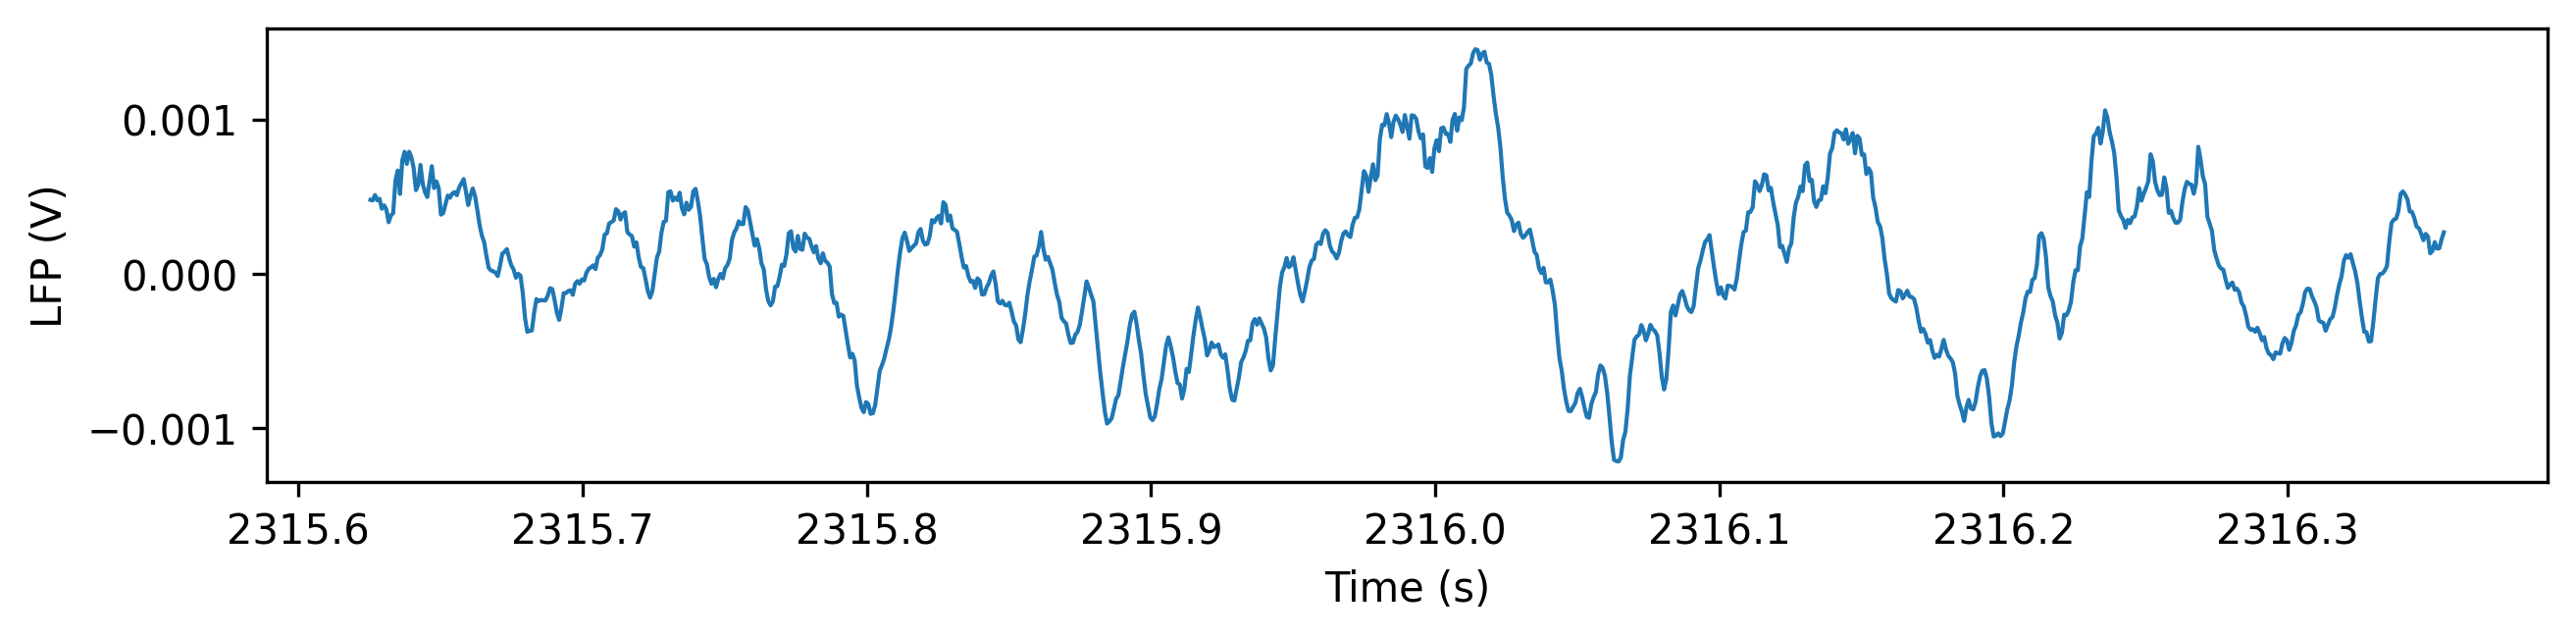

In [84]:
rip_num = global_ripples.index[1]

rip_begin = global_ripples.start_time[rip_num]-0.25
rip_end = global_ripples.end_time[rip_num]+0.25

this_chan_slice = this_chan.sel(time=slice(rip_begin, rip_end))

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(this_chan_slice.time, this_chan_slice, linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

In [49]:
ca1_units = session.units[session.units.structure_acronym=='CA1']
ca1_units.head()

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951852725,0.185243,73.096335,0.017414,161,467.40,4.109028,0.572353,0.231237,33.985943,0.098319,...,382.0,CA1,7194.0,1993.0,7224.0,probeA,See electrode locations,29999.966623,1249.998609,True
951852868,0.255439,78.110955,0.039647,173,134.56,2.435991,11.362371,0.055154,74.120064,0.025050,...,382.0,CA1,7114.0,1784.0,7302.0,probeA,See electrode locations,29999.966623,1249.998609,True
951852855,0.209786,61.880520,0.050680,172,421.35,1.933470,2.266674,0.390708,44.112921,0.036525,...,382.0,CA1,7114.0,1784.0,7302.0,probeA,See electrode locations,29999.966623,1249.998609,True
951852902,0.379141,108.370860,0.002051,176,122.29,5.115194,5.316088,0.004021,83.002939,0.001270,...,382.0,CA1,7108.0,1767.0,7309.0,probeA,See electrode locations,29999.966623,1249.998609,True
951853009,0.220373,113.318595,0.003368,185,162.90,3.853246,1.901577,0.178064,39.820442,0.034563,...,382.0,CA1,7075.0,1679.0,7350.0,probeA,See electrode locations,29999.966623,1249.998609,True


<AxesSubplot:>

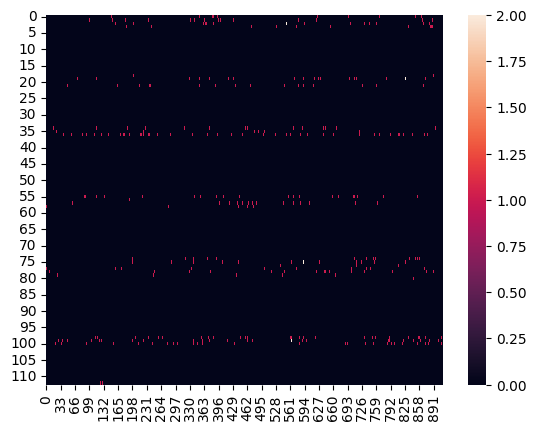

In [50]:
# this is an examples of how to work the code, it is not the final code
# but without the whole time series you can't see the relative spike rate of the units
ca1_units = session.units[session.units['structure_acronym']=='CA1']
ca1_units_ids = ca1_units.index

ca1_units_firing_df = unit_spike_times_alyx_format(session, ca1_units_ids, start_time=rip_begin, stop_time=rip_end, as_array=False)

duration = rip_end - rip_begin
n_samples = SAMPLING_FREQUENCY * duration
time_vec = simulate_time(n_samples, SAMPLING_FREQUENCY)

spike_time_histogram, unit_ids, times  = np.histogram2d(
    x=ca1_units_firing_df.units.to_numpy(),
    y=ca1_units_firing_df.times.to_numpy(),
    bins=(len(ca1_units_ids), time_vec.shape[0]))

sns.heatmap(spike_time_histogram)

In [51]:
# without specifying the time range you get the whole session
ca1_units_firing_df = unit_spike_times_alyx_format(session, ca1_units_ids, as_array=False)

duration = ca1_units_firing_df.times.to_numpy()[-1]
sampling_window_in_freq = 500
n_samples = sampling_window_in_freq * duration
time_vec = simulate_time(n_samples, SAMPLING_FREQUENCY)

# the histogram gieves us binned spiking activity, in this case in a window of 0.01s (10ms),
# this is not the same time bin as the lfp, we are then going to smooth it and z_score it
# then we will compare it to the lfp
# times is a vector that can be used as a bool mask to filter for times of interest
spike_time_histogram, unit_ids, times  = np.histogram2d(
    x=ca1_units_firing_df.units.to_numpy(),
    y=ca1_units_firing_df.times.to_numpy(),
    bins=(len(ca1_units_ids), time_vec.shape[0]))

#times = np.append(times, times[-1]+0.01)
# converting binned spikes to frequency and z_scoring them
frequency_matrix = spike_time_histogram*sampling_window_in_freq
frequency_matrix = halfgaussian_filter1d(spike_time_histogram, sigma = 0.015)
zscore_frequency_matrix = stats.zscore(frequency_matrix)


<AxesSubplot:>

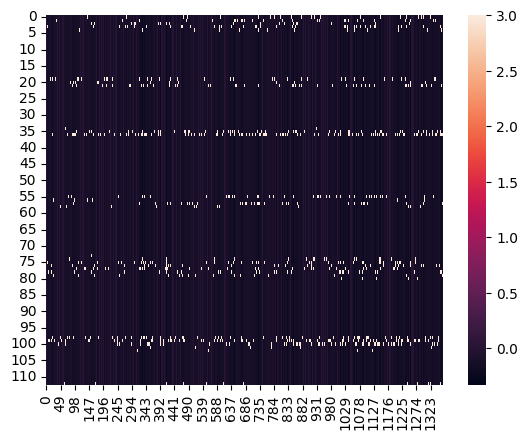

In [52]:
# plotting the zscored frequency matrix
rip_offset = 1
rip_time_mask = (times>(rip_begin-rip_offset))&(times<(rip_end+rip_offset))

# keeps the pltos scale from being too wide
plotting_mtrx = np.clip(zscore_frequency_matrix[:,rip_time_mask[:-1]], a_min=None, a_max=3)
# replaces the nan values with 0 to avoid producing ugly white stripes
plotting_mtrx = np.nan_to_num(plotting_mtrx)
sns.heatmap(plotting_mtrx)

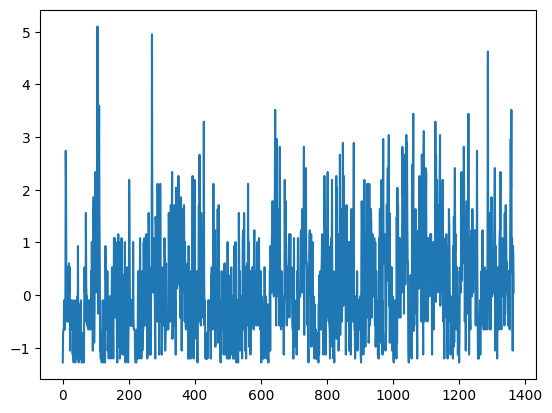

In [53]:
test = np.sum(spike_time_histogram, axis=0)

frequency = halfgaussian_filter1d(test, sigma = 0.5)
zscore_frequency = stats.zscore(frequency)
plt.plot(zscore_frequency[rip_time_mask[:-1]])

In [55]:
ripples_df = probe_event_dict[probe_list[0]]
ripples_df = ripples_df[ripples_df.Overlaps_with_gamma==False]
ripples_df = ripples_df[ripples_df.Overlaps_with_movement==False]

In [56]:
highest_peaks = ripples_df['max_zscore'].nlargest(5).index
highest_peaks

Int64Index([808, 106, 385, 1159, 203], dtype='int64')

0.1888005078426431


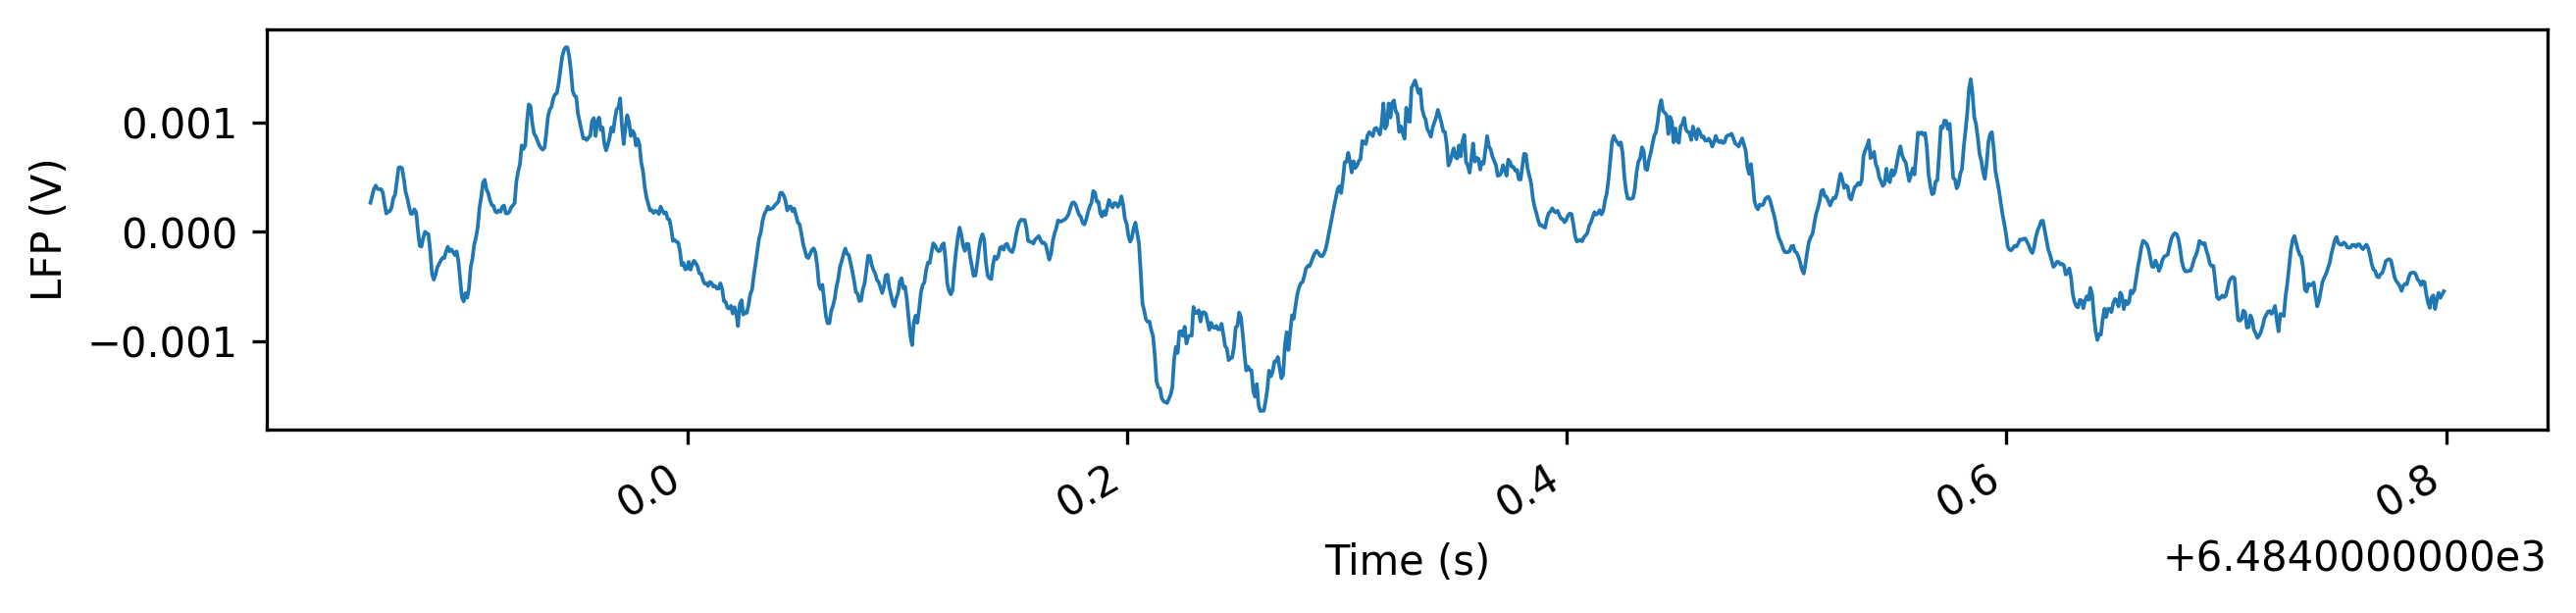

In [57]:
rip_num = highest_peaks[0]
print(ripples_df.duration[rip_num])
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset

this_chan_slice = this_chan.sel(time=slice(rip_begin, rip_end))

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(this_chan_slice.time, this_chan_slice, linewidth=0.9)



plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

plt.gcf().autofmt_xdate()

0.1888005078426431


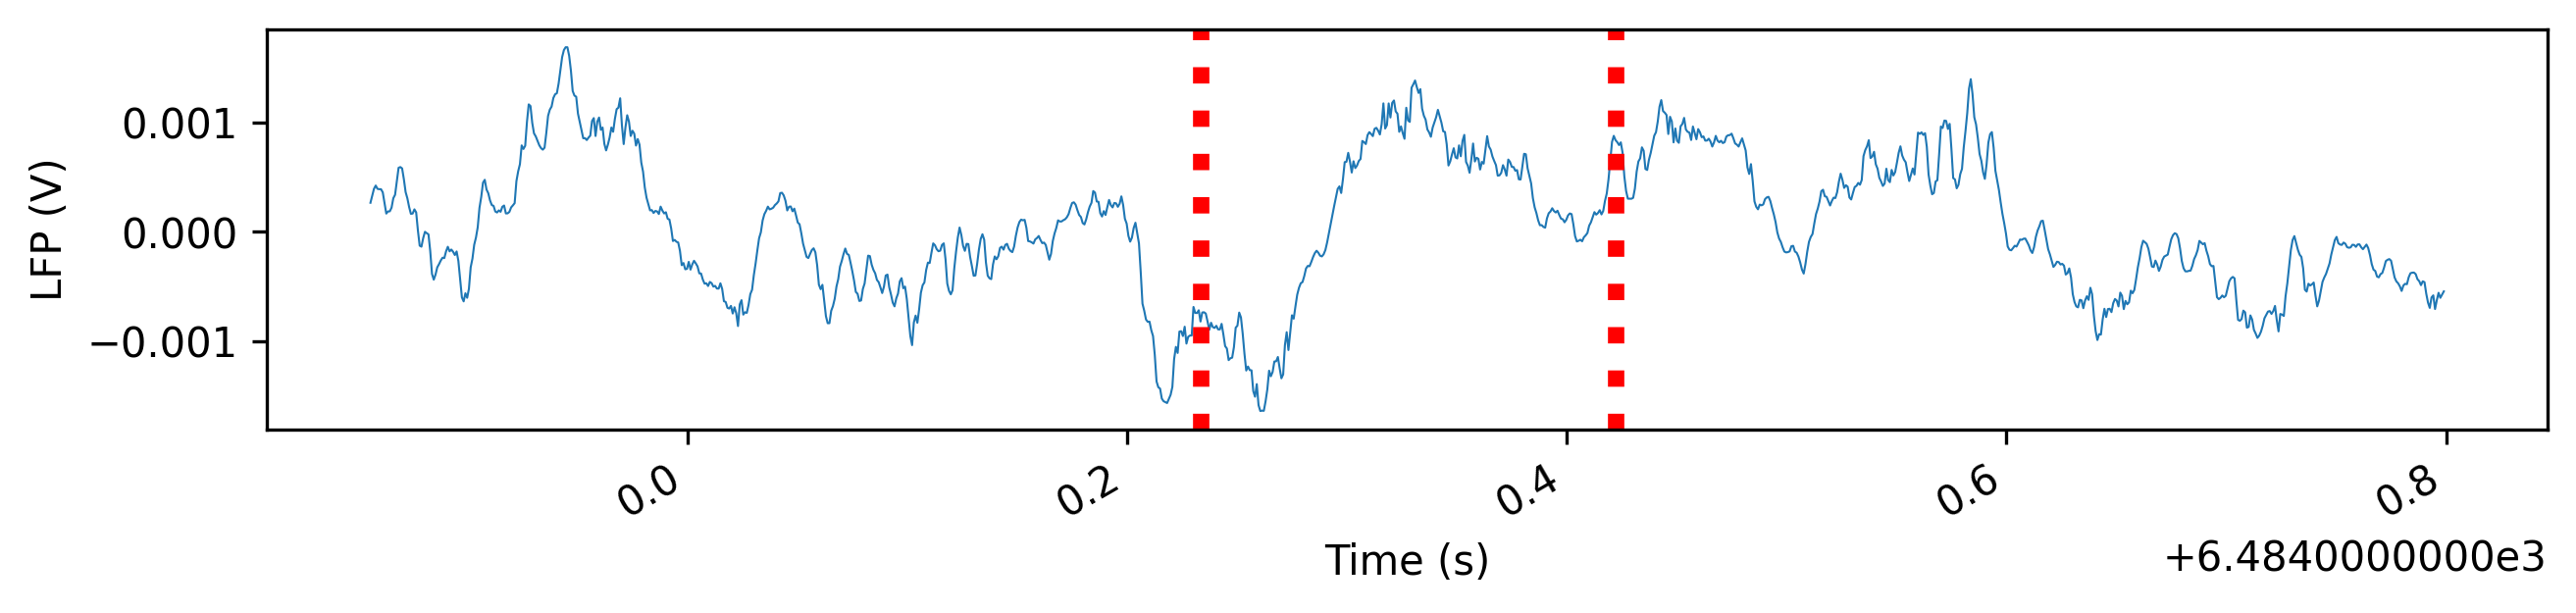

In [76]:
rip_num = highest_peaks[0]
print(ripples_df.duration[rip_num])
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset

this_chan_slice = this_chan.sel(time=slice(rip_begin, rip_end))

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(this_chan_slice.time, this_chan_slice, linewidth=0.5)

# Add red dotted lines
plt.axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)


plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

plt.gcf().autofmt_xdate()

0.1888005078426431


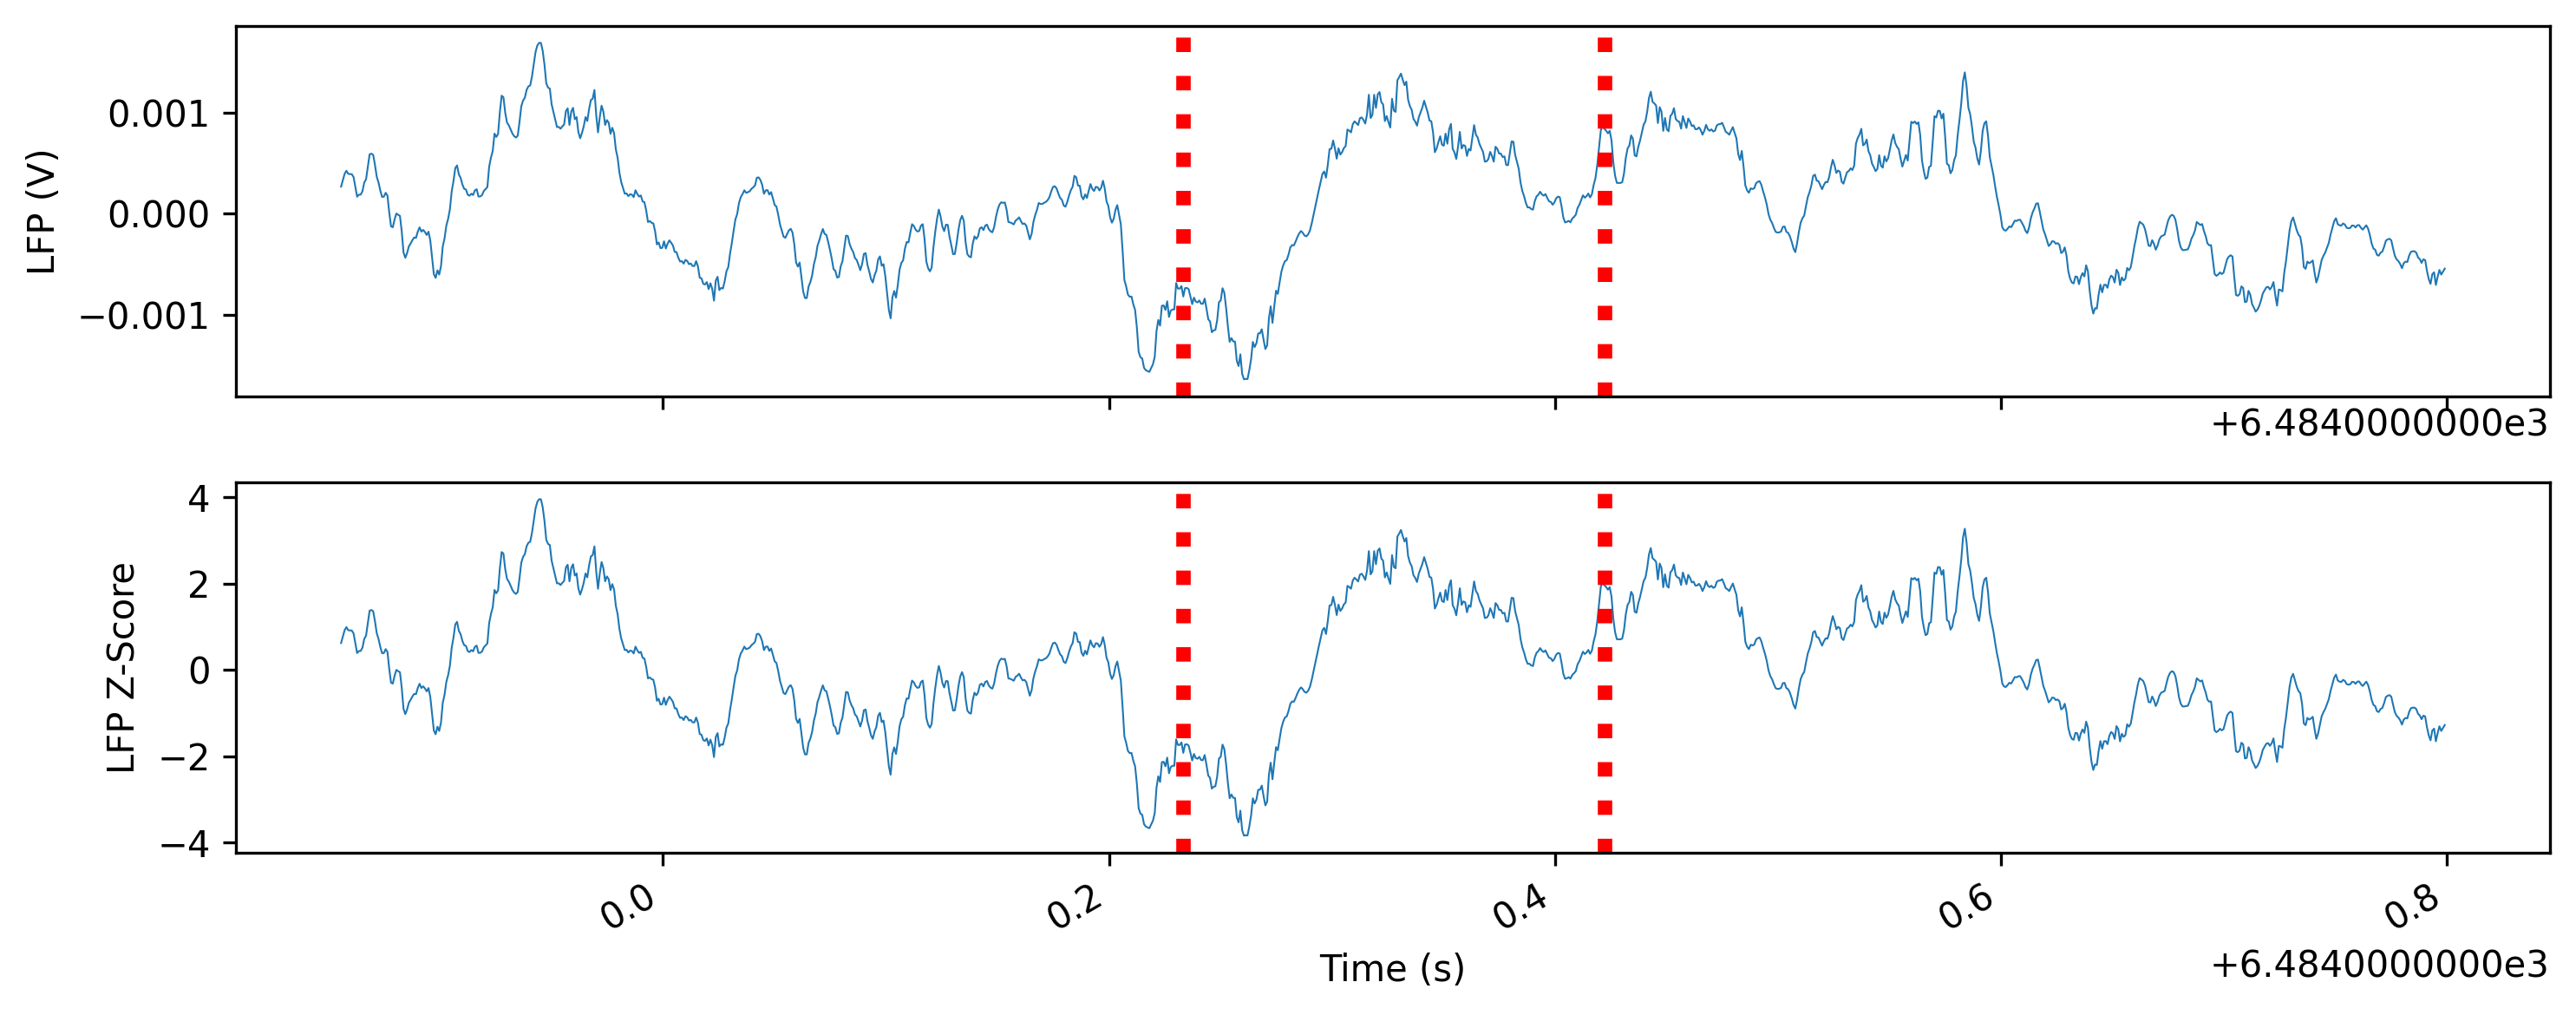

In [89]:
rip_num = highest_peaks[0]
print(ripples_df.duration[rip_num])
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset
time_arr = this_chan.time.to_numpy()
rip_mask = (time_arr >= rip_begin) & (time_arr <= rip_end)


this_chan_slice = this_chan.sel(time=slice(rip_begin, rip_end))
raw_lfp_zscore_slice = raw_lfp_zscore[rip_mask]

fig, axs = plt.subplots(2, 1, figsize=(10,4), dpi=300)

# Plot original LFP data
axs[0].plot(this_chan_slice.time, this_chan_slice, linewidth=0.5)
axs[0].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].set_ylabel('LFP (V)')

# Plot z-scored LFP data
axs[1].plot(time_arr[rip_mask], raw_lfp_zscore_slice, linewidth=0.5)
axs[1].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('LFP Z-Score')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

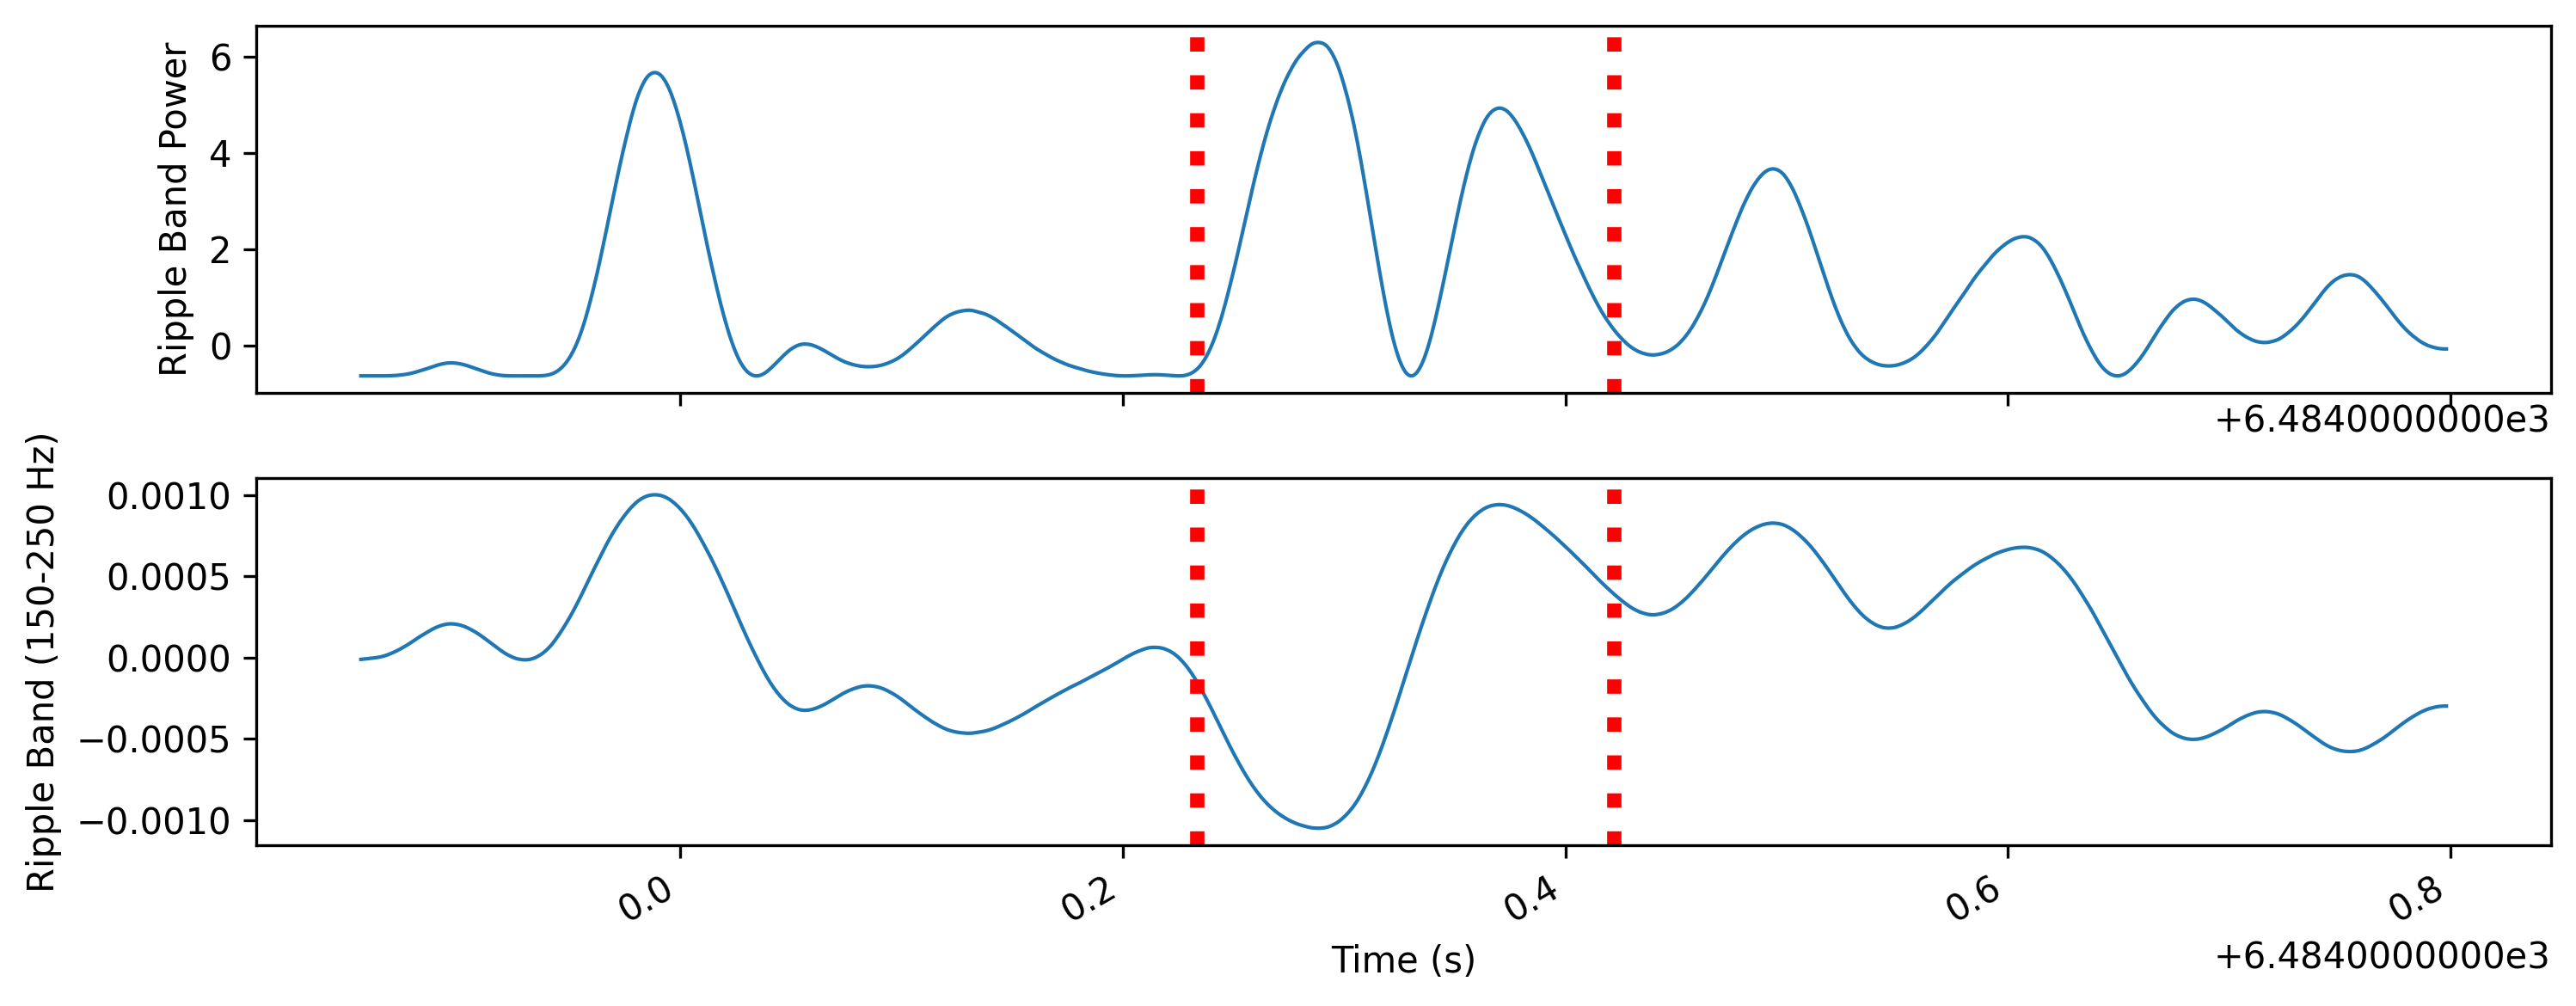

In [78]:
rip_num = highest_peaks[0]
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset

zscore_rip_power_slice = zscore_rip_power[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]
rip_band_slice = rip_band[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

fig, axs = plt.subplots(2, 1, figsize=(10,4), dpi=300)

# Plot z-scored power
axs[0].plot(this_chan_slice.time.to_numpy()[:-1], zscore_rip_power_slice, linewidth=1)
axs[0].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].set_ylabel('Ripple Band Power')

# Plot frequency band
axs[1].plot(this_chan_slice.time.to_numpy()[:-1], rip_band_slice, linewidth=1)
axs[1].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Ripple Band (150-250 Hz)')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

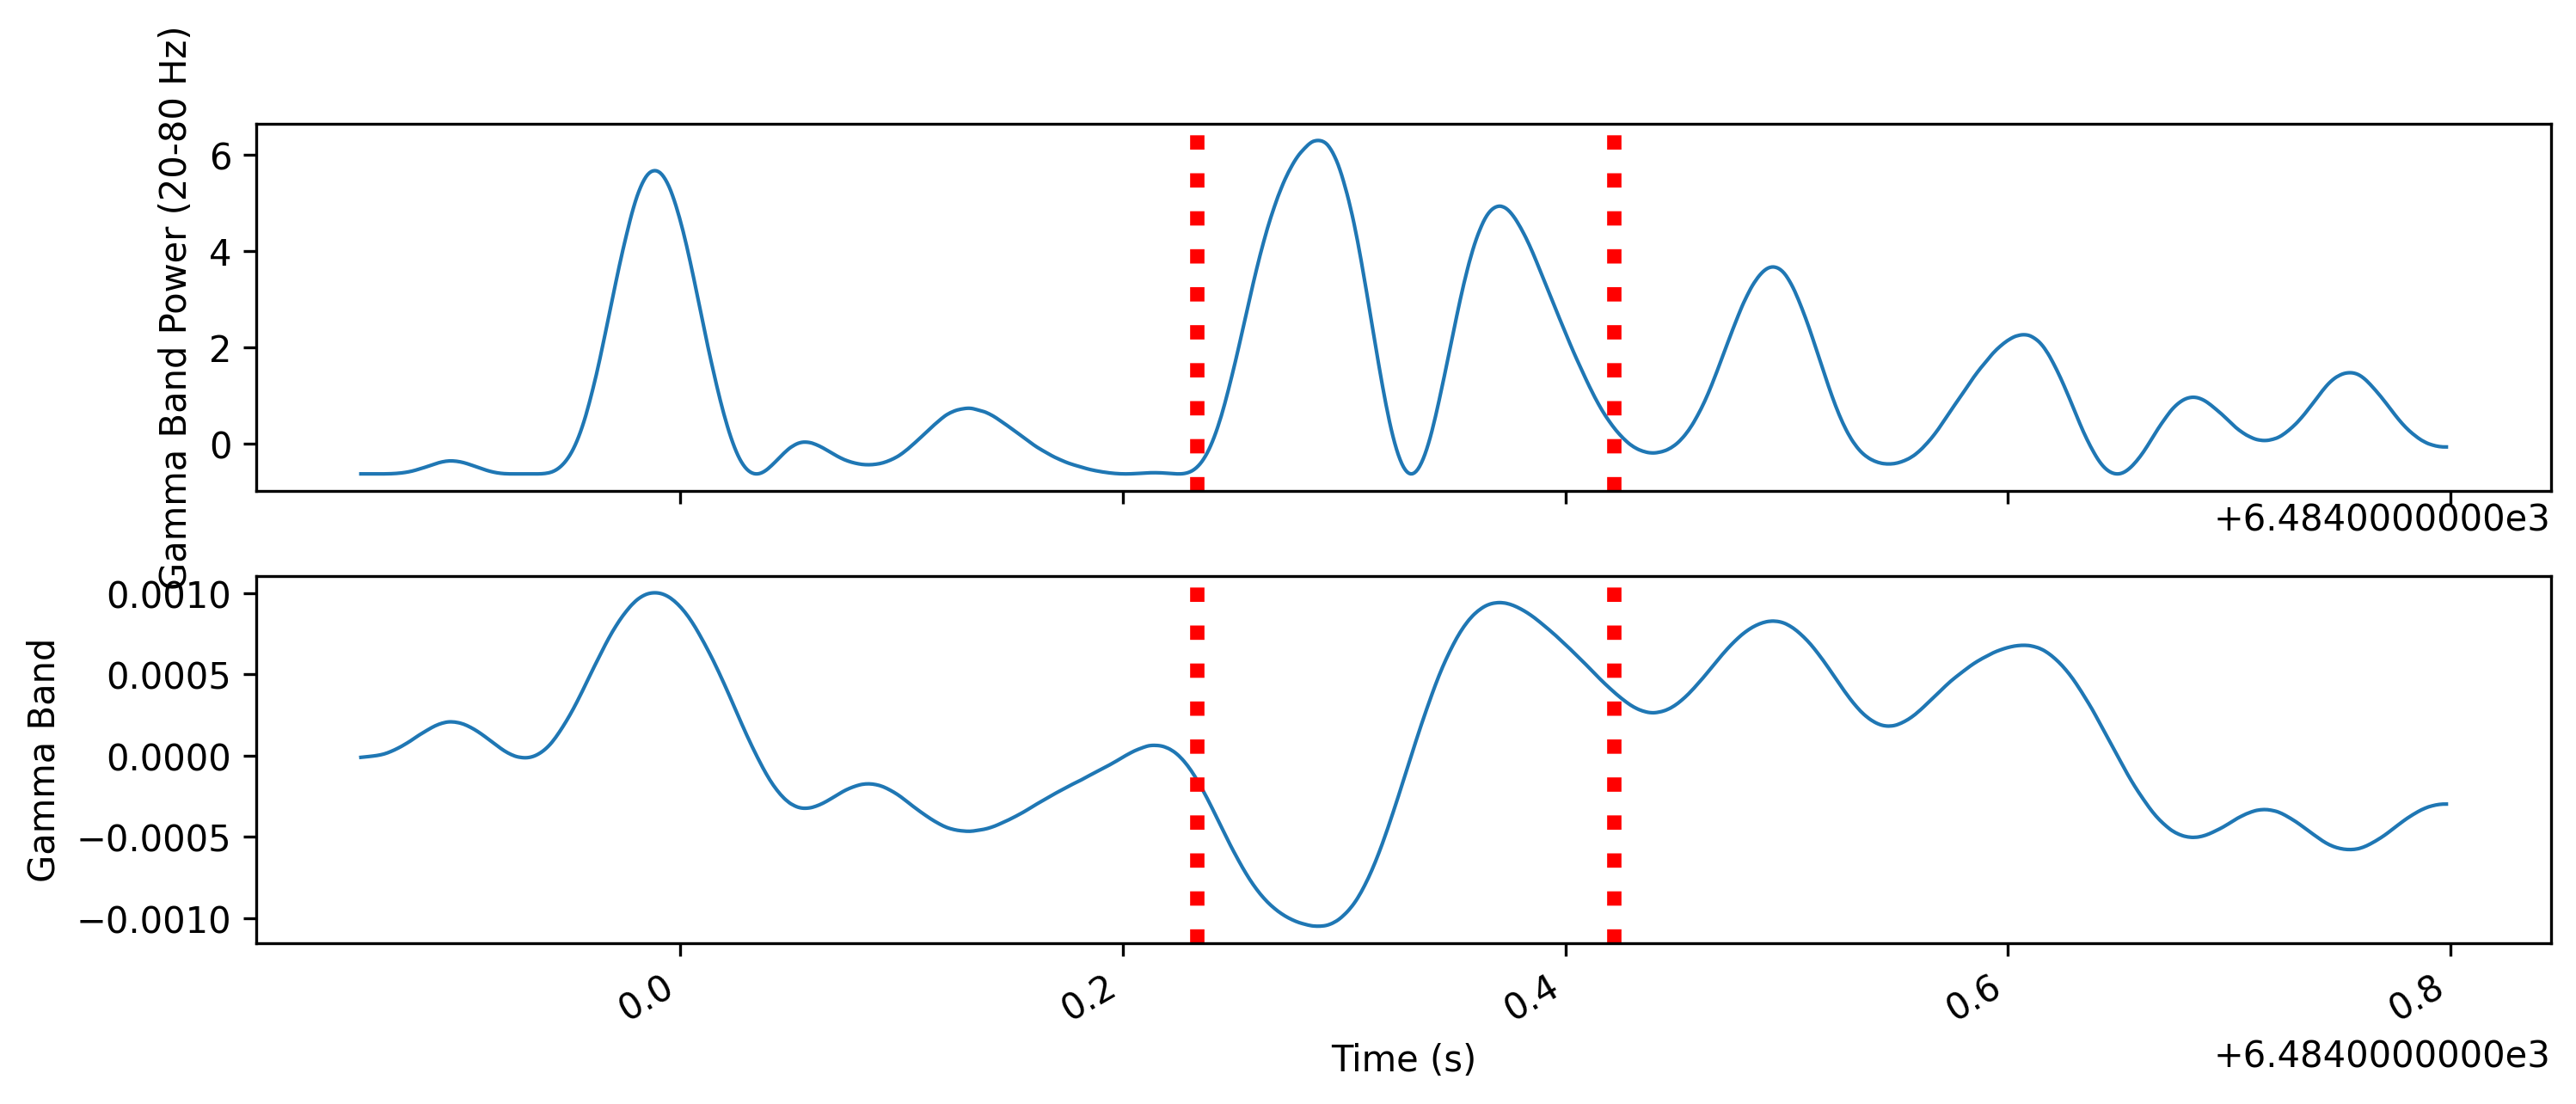

In [71]:
zscore_gamma_power_slice = zscore_gamma_power[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]
gamma_band_slice = gamma_band[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

fig, axs = plt.subplots(2, 1, figsize=(10,4), dpi=300)

# Plot z-scored power
axs[0].plot(this_chan_slice.time.to_numpy()[:-1], zscore_gamma_power_slice, linewidth=1)
axs[0].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].set_ylabel('Gamma Band Power (20-80 Hz)')

# Plot frequency band
axs[1].plot(this_chan_slice.time.to_numpy()[:-1], gamma_band_slice, linewidth=1)
axs[1].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Gamma Band')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

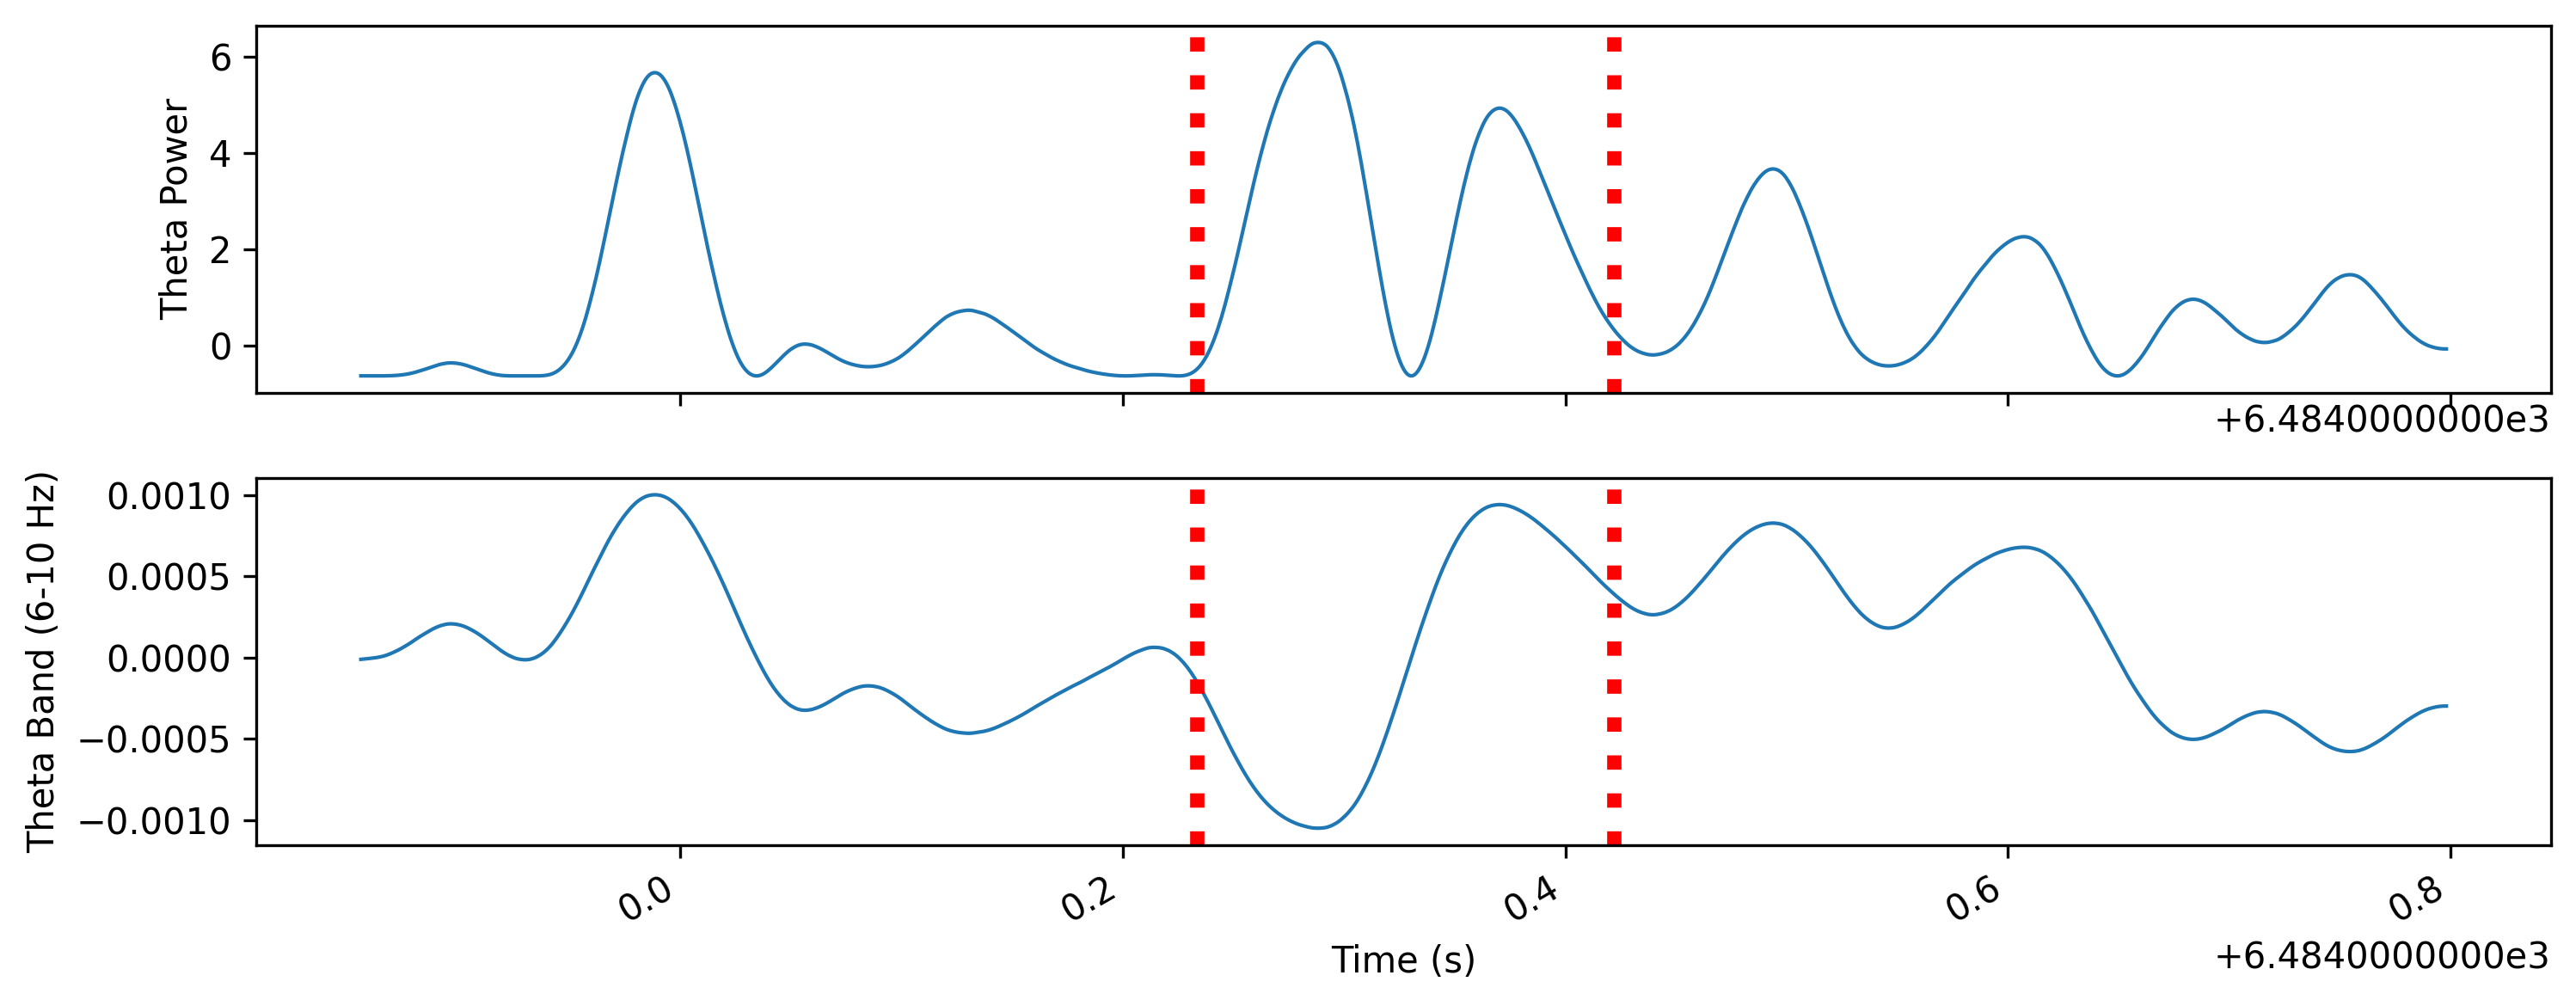

In [73]:
zscore_theta_power_slice = zscore_theta_power[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]
theta_band_slice = theta_band[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

fig, axs = plt.subplots(2, 1, figsize=(10,4), dpi=300)

# Plot z-scored power
axs[0].plot(this_chan_slice.time.to_numpy()[:-1], zscore_theta_power_slice, linewidth=1)
axs[0].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].set_ylabel('Theta Power')

# Plot frequency band
axs[1].plot(this_chan_slice.time.to_numpy()[:-1], theta_band_slice, linewidth=1)
axs[1].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Theta Band (6-10 Hz)')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
rip_num = highest_peaks[0]
print(ripples_df.duration[rip_num])
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset

zscore_sharpwave_power_slice = zscore_sharpwave_power[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(this_chan_slice.time.to_numpy()[:-1], zscore_sharpwave_power_slice, linewidth=1)

# Add red dotted lines
plt.axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)


plt.xlabel('Time (s)')
plt.ylabel('Sharp-Wave Power (8-40 Hz)')

plt.gcf().autofmt_xdate()

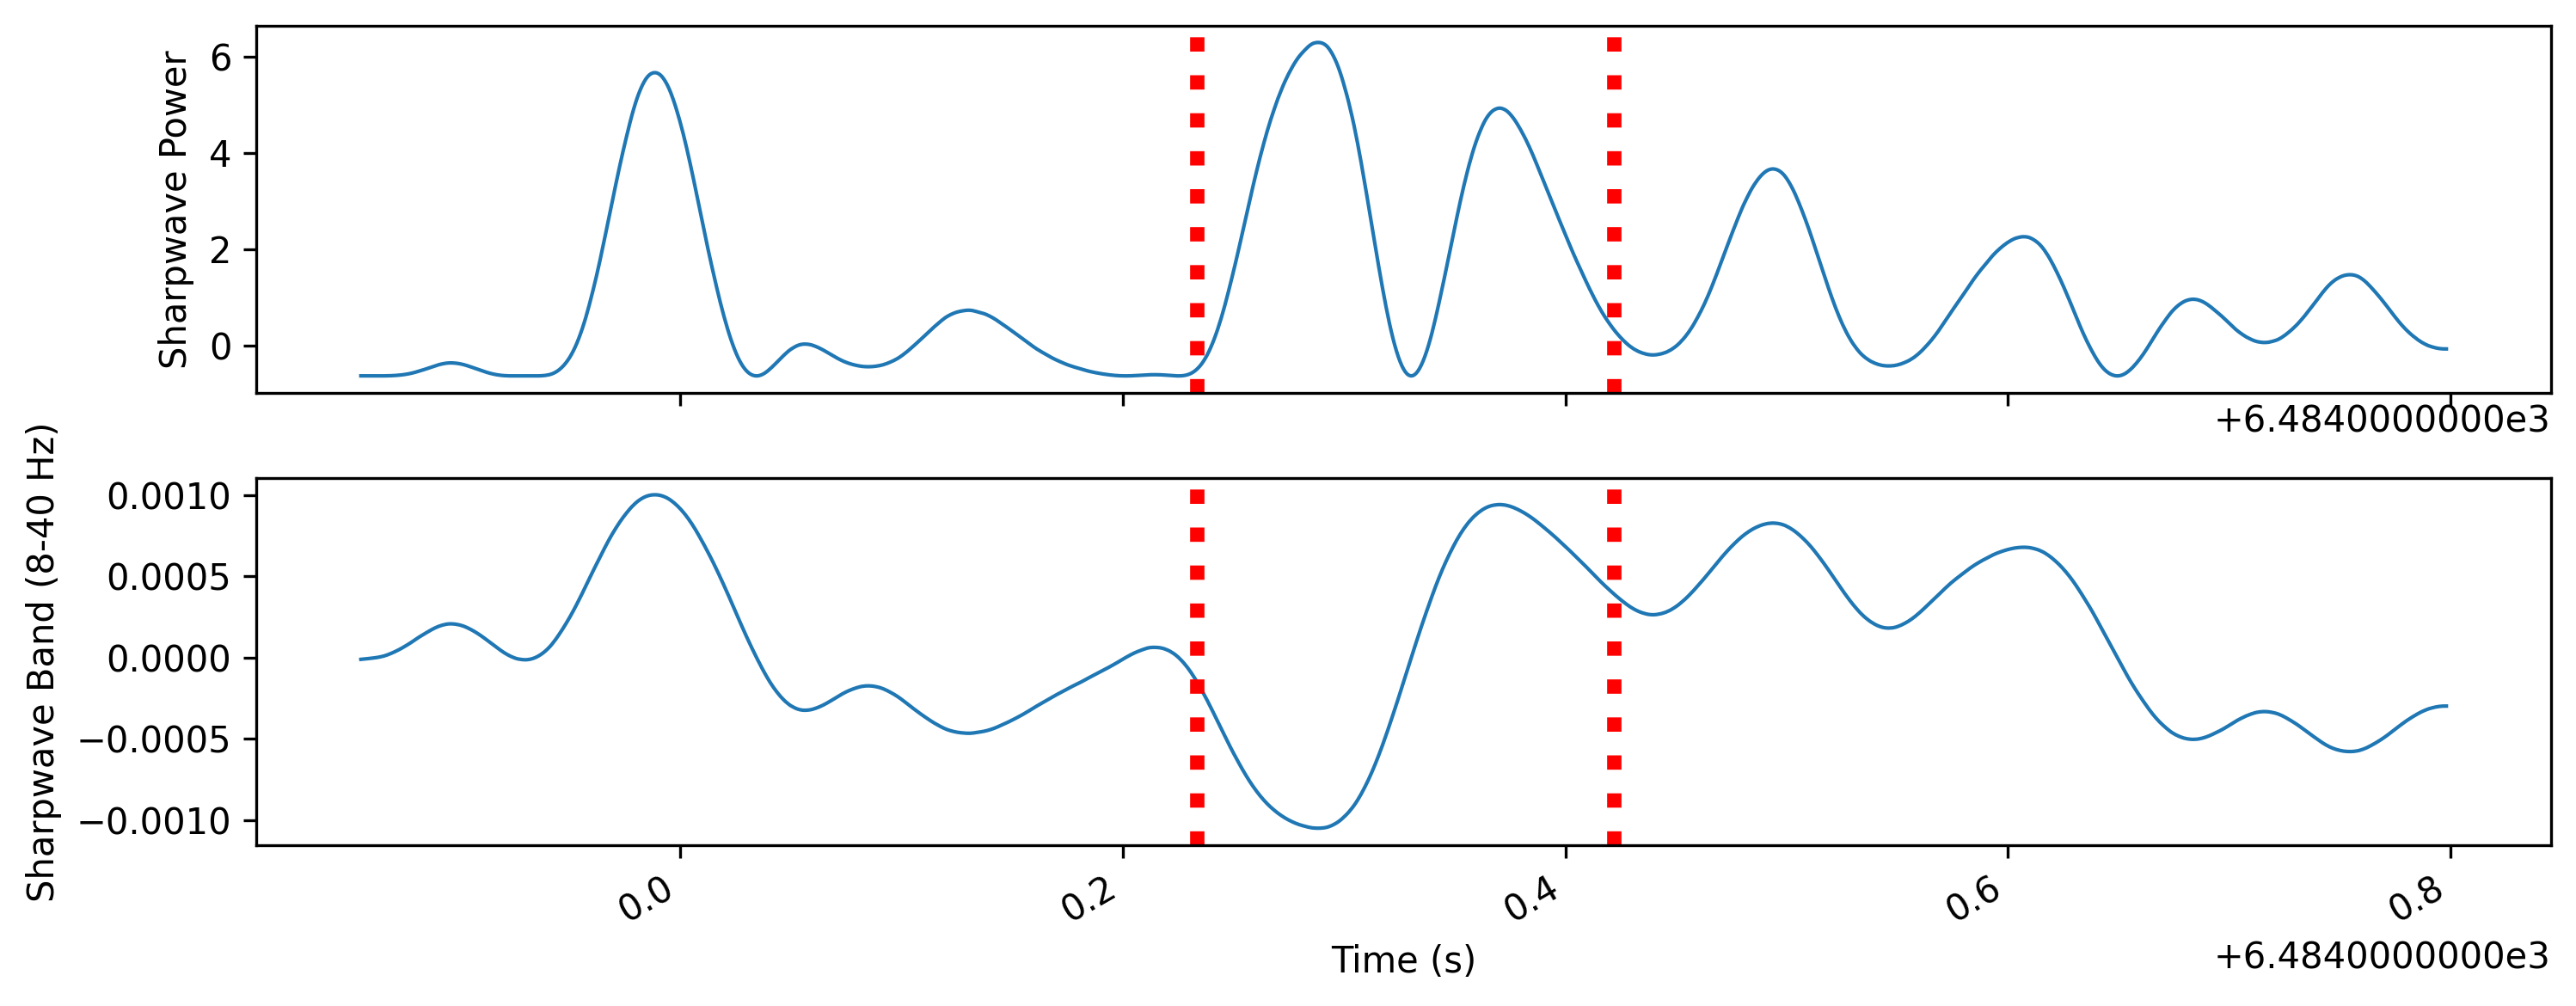

In [72]:
zscore_sharpwave_power_slice = zscore_sharpwave_power[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]
sharpwave_band_slice = sharpwave_band[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

fig, axs = plt.subplots(2, 1, figsize=(10,4), dpi=300)

# Plot z-scored power
axs[0].plot(this_chan_slice.time.to_numpy()[:-1], zscore_sharpwave_power_slice, linewidth=1)
axs[0].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].set_ylabel('Sharpwave Power')

# Plot frequency band
axs[1].plot(this_chan_slice.time.to_numpy()[:-1], sharpwave_band_slice, linewidth=1)
axs[1].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Sharpwave Band (8-40 Hz)')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

0.1888005078426431


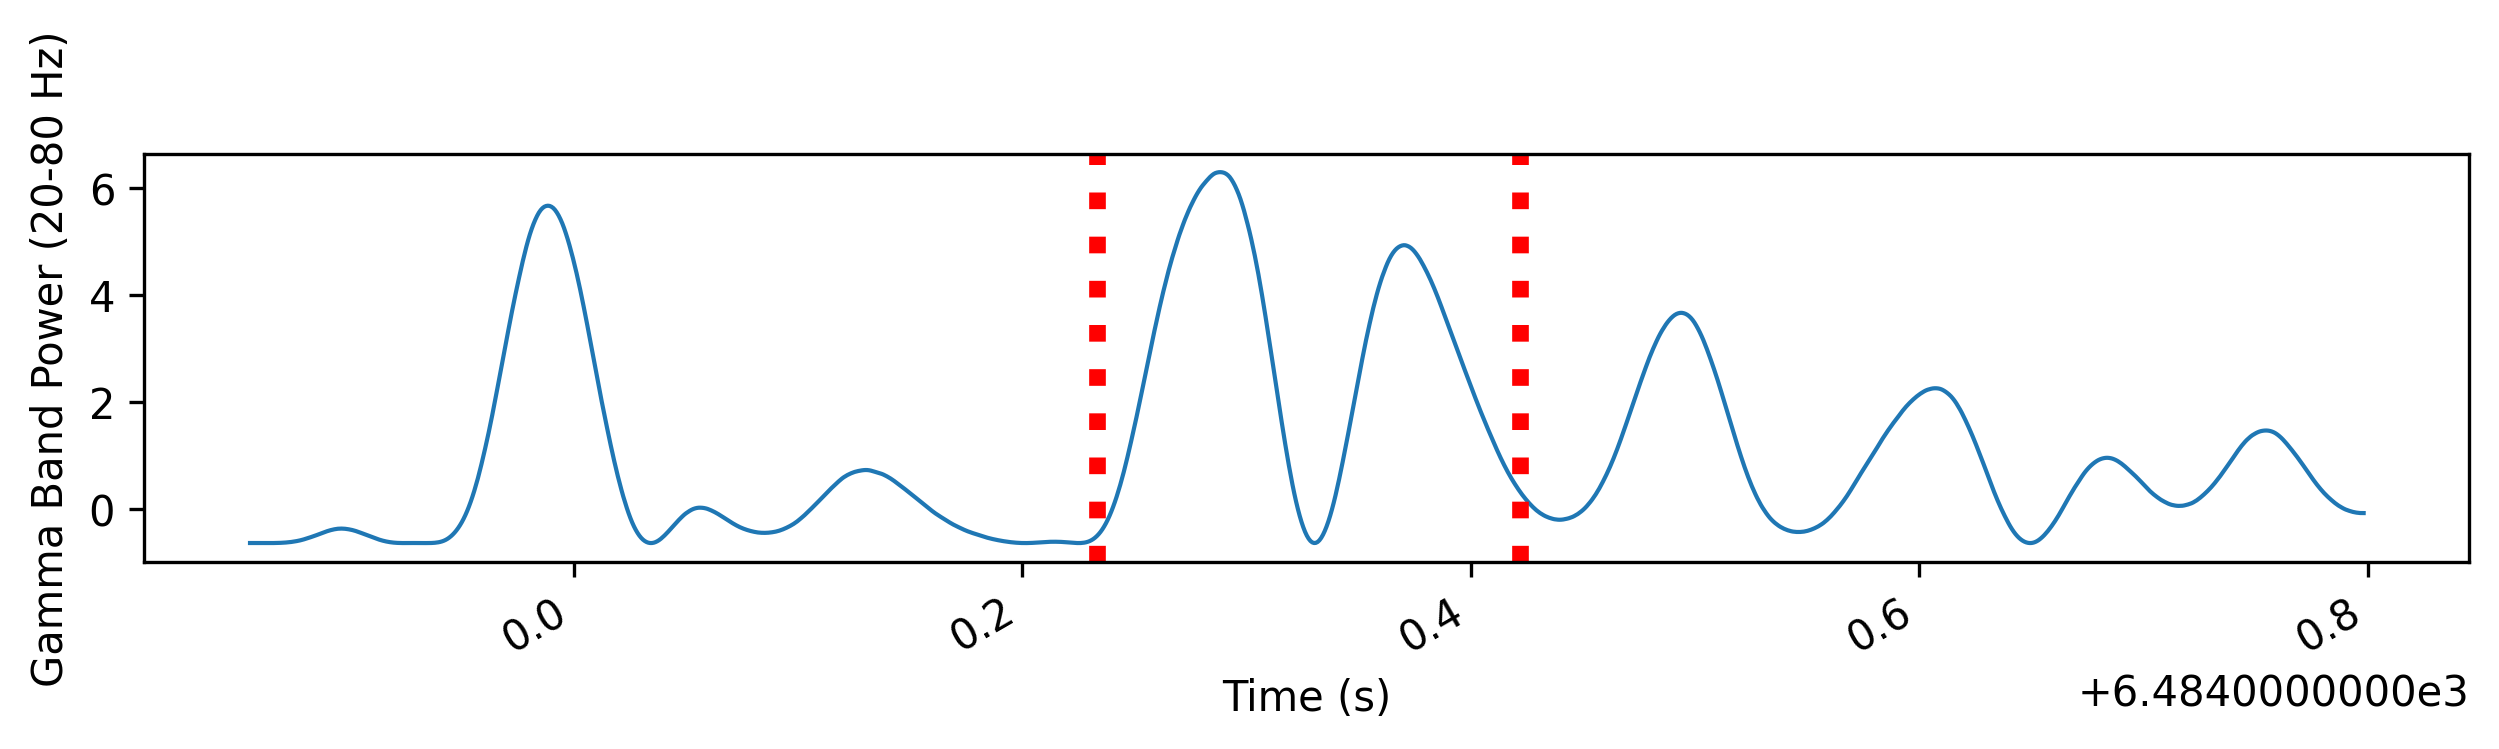

In [ ]:
rip_num = highest_peaks[0]
print(ripples_df.duration[rip_num])
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset

zscore_gamma_power_slice = zscore_gamma_power[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(this_chan_slice.time.to_numpy()[:-1], zscore_gamma_power_slice, linewidth=1)

# Add red dotted lines
plt.axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)


plt.xlabel('Time (s)')
plt.ylabel('Gamma Band Power (20-80 Hz)')

plt.gcf().autofmt_xdate()

0.1888005078426431


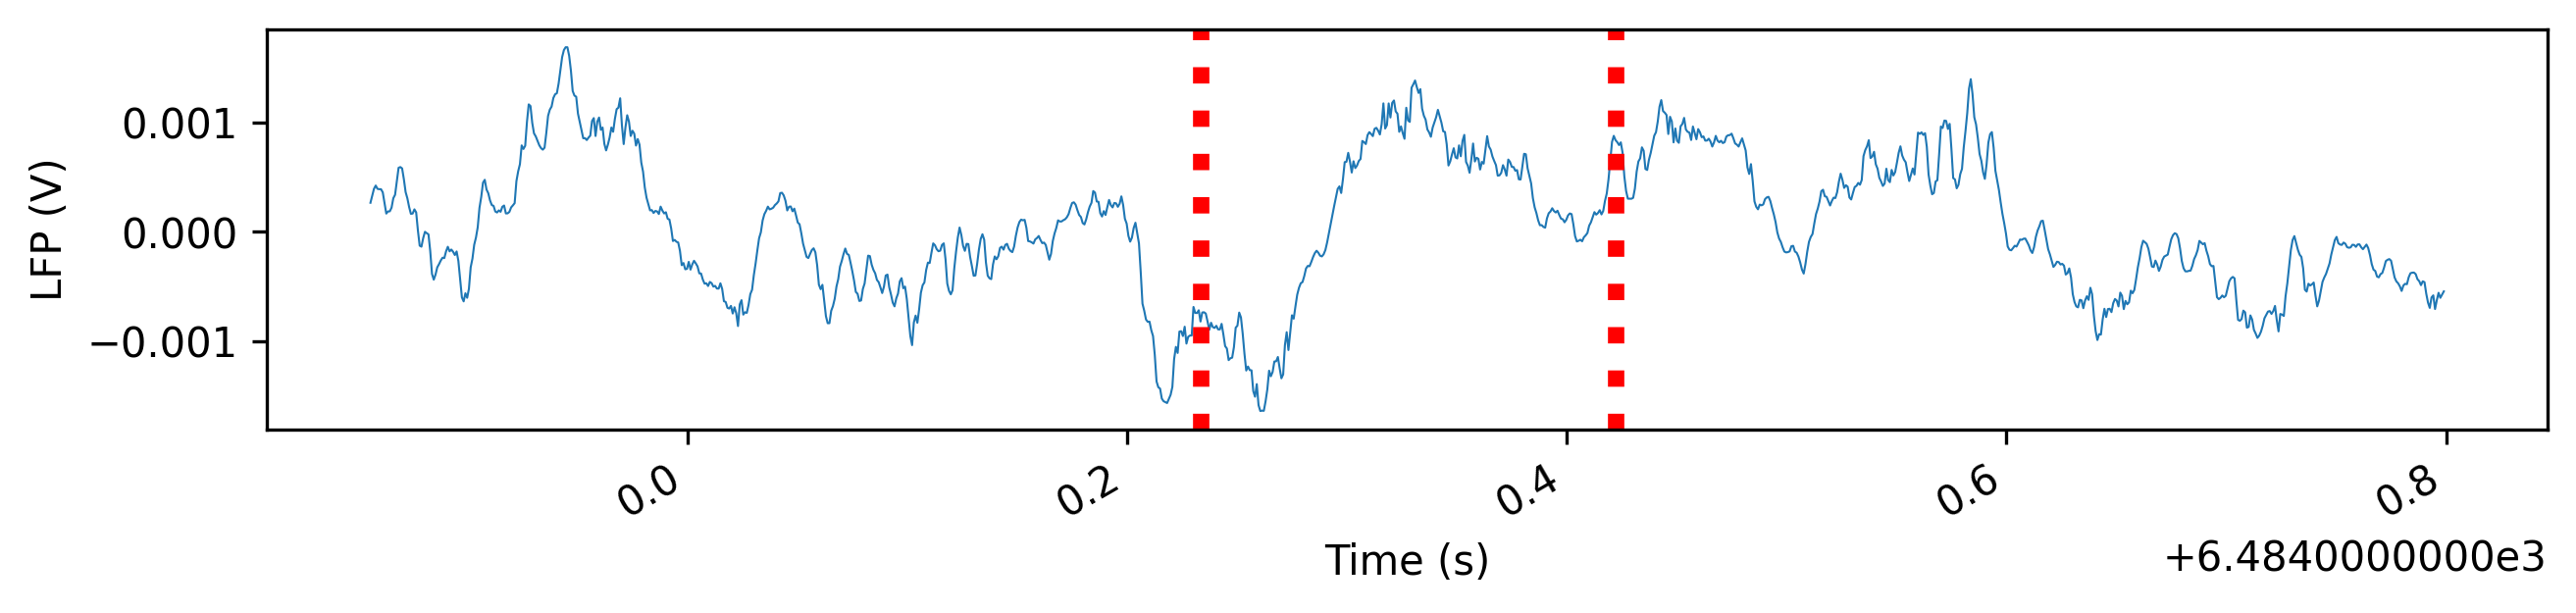

In [63]:
rip_num = highest_peaks[0]
print(ripples_df.duration[rip_num])
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset

this_chan_slice = this_chan.sel(time=slice(rip_begin, rip_end))

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(this_chan_slice.time, this_chan_slice, linewidth=0.5)

# Add red dotted lines
plt.axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)


plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

plt.gcf().autofmt_xdate()

In [64]:
# Create an array of multiples of 0.25 within the range of your data
multiples = np.arange(np.min(actual_time_values), np.max(actual_time_values), 0.25)#multiples
# Find the index of the closest value in your data for each multiple
closest_indices = [np.abs(actual_time_values - m).argmin() for m in multiples]
closest_values = actual_time_values[closest_indices]
closest_values

NameError: name 'actual_time_values' is not defined

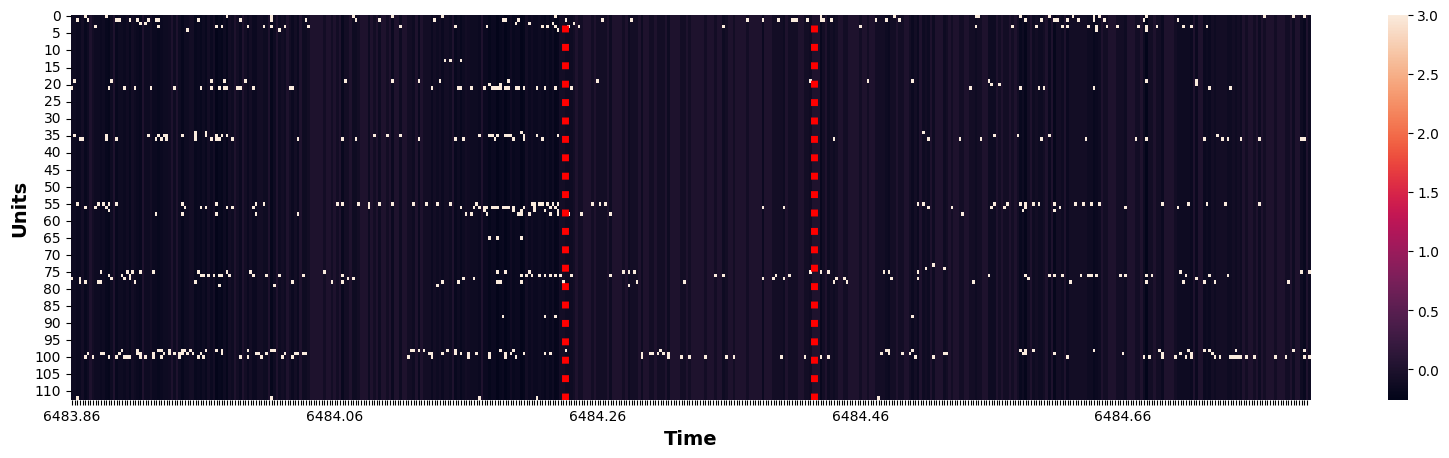

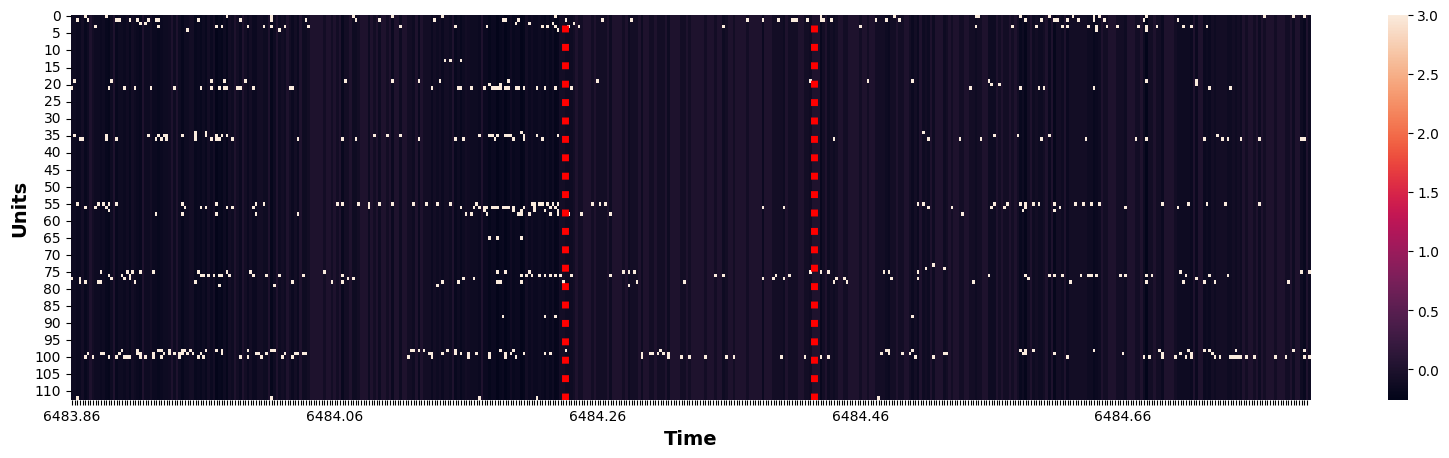

In [ ]:
# plotting the zscored frequency matrix
rip_offset = (lasts*2)
rip_time_mask = (times>rip_begin)&(times<rip_end) # already incorperates offset


actual_time_values = times[rip_time_mask]
actual_time_values = actual_time_values[:-1]
# Create an array of multiples of 0.25 within the range of your data
multiples = np.arange(np.min(actual_time_values), np.max(actual_time_values), 0.2)#multiples
# Find the index of the closest value in your data for each multiple
closest_indices = [np.abs(actual_time_values - m).argmin() for m in multiples]
closest_values = actual_time_values[closest_indices]
closest_values = np.round(closest_values, 2)
mapping = dict(zip(closest_indices, closest_values))

# Create a new list of labels with the same length as the number of columns in the data
labels = [''] * len(actual_time_values)

# Set the labels for the indices corresponding to the closest values to multiples of 0.25
for i in range(len(actual_time_values)):
    if i in mapping:
        labels[i] = str(mapping[i])

# keeps the pltos scale from being too wide
plotting_mtrx = np.clip(zscore_frequency_matrix[:,rip_time_mask[:-1]], a_min=None, a_max=3)
plotting_mtrx = np.nan_to_num(plotting_mtrx)
# replaces the nan values with 0 to avoid producing ugly white stripes
# Find the indices of rip_begin and rip_end in actual_time_values
rip_begin_index = np.abs(actual_time_values - ripples_df.start_time[rip_num]).argmin()
rip_end_index = np.abs(actual_time_values - ripples_df.end_time[rip_num]).argmin()

# Create the heatmap
plt.figure(figsize=(20, 5))
ax = sns.heatmap(plotting_mtrx, xticklabels=labels)

# Add vertical lines at rip_begin and rip_end
ax.axvline(x=rip_begin_index, color='r', linestyle=':', linewidth=5)
ax.axvline(x=rip_end_index, color='r', linestyle=':', linewidth=5)

# Set x and y axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Units')

ax.set_xlabel('Time', fontsize=14, weight='bold')
ax.set_ylabel('Units', fontsize=14, weight='bold')
plt.show()

In [ ]:
def unit_spike_times_alyx_format(session_obj, unit_ids, start_time=0, stop_time=np.inf, as_array=False):
    """
    Returns a DataFrame of spike times for multiple units in a session in the format
    according to the Alyx format
    
    Parameters
    ----------
    session : allensdk session object
    unit_ids : list of unit ids (obtained by session.units.index)
    start_time : float, optional, start time of spike times
    stop_time : float, optional, stop time of spike times
    as_array : bool, optional, if True returns a numpy array instead of a DataFrame
    
    Returns
    -------
    DataFrame or numpy array of spike times
    """
    df = pd.DataFrame(columns=['units', 'times'])

    for unit_id in unit_ids:
        ca1_unit_time = np.array(session_obj.spike_times[unit_id])
        filtered_time = ca1_unit_time[(ca1_unit_time > start_time) & (ca1_unit_time < stop_time)]
        unit_ids_array = np.full(filtered_time.shape, unit_id)
        
        df_temp = pd.DataFrame({
            'units': unit_ids_array,
            'times': filtered_time
        })
        
        df = df.append(df_temp, ignore_index=True)

    df = df.sort_values(by='times')

    if as_array:
        return df.values
    else:
        return df

In [ ]:

def filter_time(session, unit_ids, start_time=0, stop_time=np.inf):
    unit_id = unit_ids[0]
    ca1_unit_time = np.array(session.spike_times[unit_id])
    filtered_time = ca1_unit_time[(ca1_unit_time > start_time) & (ca1_unit_time < stop_time)]
    unit_ids_array = np.full(filtered_time.shape, unit_id)
    
    df = pd.DataFrame({
        'units': unit_ids_array,
        'times': filtered_time
    })

    for unit_id in unit_ids[1:]:
        ca1_unit_time = np.array(session.spike_times[unit_id])
        filtered_time = ca1_unit_time[(ca1_unit_time > start_time) & (ca1_unit_time < stop_time)]
        unit_ids_array = np.full(filtered_time.shape, unit_id)
        
        df_temp = pd.DataFrame({
            'units': unit_ids_array,
            'times': filtered_time
        })
        
        df = df.append(df_temp, ignore_index=True)

In [ ]:
# get unit id's from CA1

ca1_unit_times = presentationwise_spike_times( unit_ids=ca1_units)